## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Import modules, set options

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
INPUT_ADDED = '..\\input_added'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [5]:
train_csv, _ = train_test_split(train_csv, test_size=0.99, random_state=42)

#### Train_CSV Params

In [6]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,6.915783e+04,1.335689e+01,5.883966e+00,1.589904e+01
std,3.661127e+04,3.267712e+00,4.993943e+00,3.477050e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,3.900200e+04,1.100000e+01,2.000000e+00,-2.549780e-01
50%,7.160900e+04,1.300000e+01,5.000000e+00,2.281130e+00
75%,1.008060e+05,1.600000e+01,8.000000e+00,7.390655e+00
max,1.338840e+05,2.800000e+01,2.800000e+01,2.048800e+02


In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))



def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [21]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [22]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

## Functions

In [23]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df


def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)
        
    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['x_c', 'y_c', 'z_c', 
        'molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms


In [24]:
def add_distance_to_center(df):
    df['d_c'] = ((
        ( df['x'] -  df['x_c'])**np.float32(2) +
        ( df['y'] -  df['y_c'])**np.float32(2) + 
        ( df['z'] -  df['z_c'])**np.float32(2)
    )**np.float32(0.5))
    

def cross_prod(v1, v2):
    outp0 = v1[1] * v2[2] - v1[2] * v2[1]
    outp1 = v1[2] * v2[0] - v1[0] * v2[2]
    outp2 = v1[0] * v2[1] - v1[1] * v2[0]
    outp = pd.concat([outp0, outp1,outp2], axis=1)
    return outp


def add_axis_x(df):
    n_x = df.x_0 - df.x_c
    n_y = df.y_0 - df.y_c
    n_z = df.z_0 - df.z_c
    axisFrame = pd.concat([n_x, n_y, n_z], axis=1)
    axisNorm = np.sqrt(np.square(axisFrame).sum(axis=1))
    df['ax_x'] = axisFrame[0] / axisNorm
    df['ax_y'] = axisFrame[1] / axisNorm
    df['ax_z'] = axisFrame[2] / axisNorm


def add_axis_y(df):
    r_vec = pd.concat([df.x_2 - df.x_c, 
                 df.y_2 - df.y_c,
                 df.z_2 - df.z_c], axis=1)
    axis_vec = pd.concat([df['ax_x'], 
                          df['ax_y'], 
                          df['ax_z']], axis=1)
    axis_vec.columns = [0, 1, 2]
    dist =  axis_vec[0] * r_vec[0] + axis_vec[1] * r_vec[1] + axis_vec[2] * r_vec[2]
    yDir = r_vec - axis_vec.multiply(dist, axis="index")
    yDirNorm = np.sqrt(np.square(yDir).sum(axis=1))
    df['ay_x'] = yDir[0] / yDirNorm
    df['ay_y'] = yDir[1] / yDirNorm
    df['ay_z'] = yDir[2] / yDirNorm    

def add_axis_z(df):    
    r_vec = pd.concat([df.x_2 - df.x_c, 
         df.y_2 - df.y_c,
         df.z_2 - df.z_c], axis=1)
    axis_x_vec = pd.concat([df['ax_x'], 
                      df['ax_y'], 
                      df['ax_z']], axis=1)
    axis_x_vec.columns = [0, 1, 2]
    axis_y_vec = pd.concat([df['ay_x'], 
                      df['ay_y'], 
                      df['ay_z']], axis=1)
    axis_y_vec.columns = [0, 1, 2]
    axis_z_vec = cross_prod(axis_x_vec, axis_y_vec)
    df['az_x'] = axis_z_vec[0] 
    df['az_y'] = axis_z_vec[1] 
    df['az_z'] = axis_z_vec[2] 


    
#add coordinates in frame ax,ay,az
def add_r_per_atom(df, suffix):
    x_loc = df[f'x_{suffix}'] - df.x_c
    y_loc = df[f'y_{suffix}'] - df.y_c
    z_loc = df[f'z_{suffix}'] - df.z_c
    r_x =  df['ax_x'] * x_loc + df['ax_y'] * y_loc + df['ax_z'] * z_loc
    r_y =  df['ay_x'] * x_loc + df['ay_y'] * y_loc + df['ay_z'] * z_loc
    r_z =  df['az_x'] * x_loc + df['az_y'] * y_loc + df['az_z'] * z_loc
    df[f'r_x_{suffix}'] = r_x
    df[f'r_y_{suffix}'] = r_y
    df[f'r_z_{suffix}'] = r_z
            
def add_r(df):    
    n_atoms = len([col for col in df if col.startswith('x_')]) - 1
    for i in range(1, n_atoms):
            add_r_per_atom(df, i)
            
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    atoms = build_atoms(base, structures, n_atoms)
    df = add_atoms(base, atoms)
    
    add_axis_x(df)
    add_axis_y(df)
    add_axis_z(df)
    add_r(df)

    df.sort_values('id', inplace=True)
    return df


Wall time: 30.5 s


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,ax_x,ax_y,ax_z,ay_x,ay_y,ay_z,az_x,az_y,az_z,r_x_1,r_y_1,r_z_1,r_x_2,r_y_2,r_z_2,r_x_3,r_y_3,r_z_3,r_x_4,r_y_4,r_z_4,r_x_5,r_y_5,r_z_5,r_x_6,r_y_6,r_z_6,r_x_7,r_y_7,r_z_7,r_x_8,r_y_8,r_z_8,r_x_9,r_y_9,r_z_9
0,0,1,1,0,84.807602,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001,-0.005274,0.539886,0.004989,1,1,1,0,0,0,0,0,1.011731,-0.540815,-0.523814,NaN,NaN,NaN,NaN,NaN,1.463751,1.447527,1.437933,NaN,NaN,NaN,NaN,NaN,0.000277,-0.876644,0.906397,NaN,NaN,NaN,NaN,NaN,0.013598,-0.999892,-0.005518,0.999862,0.013650,-0.009453,0.009528,-0.005388,0.999940,-0.545976,-1.050371e-09,2.263989e-10,-0.909910,1.029520e+00,3.469447e-18,-0.909960,-0.514744,-0.891572,-0.909974,-0.514731,0.891575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,1,2,0,84.807404,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001,0.499516,1.274778,0.004139,1,1,1,0,0,0,0,0,0.002150,-0.523814,-0.540815,NaN,NaN,NaN,NaN,NaN,-0.006031,1.437933,1.447527,NaN,NaN,NaN,NaN,NaN,0.001976,0.906397,-0.876644,NaN,NaN,NaN,NaN,NaN,0.938163,0.346121,-0.007074,0.346062,-0.938175,-0.008353,-0.009528,0.005388,-0.999940,-0.545976,-7.734600e-09,2.711641e-10,-0.909910,1.029521e+00,-4.336809e-19,-0.909962,-0.514740,-0.891575,-0.909978,-0.514731,0.891572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,1,3,0,84.809303,-0.540815,1.447527,-0.876644,-0.012698,1.085804,0.008001,-0.276757,1.266665,-0.434321,1,1,1,0,0,0,0,0,-0.523814,0.002150,1.011731,NaN,NaN,NaN,NaN,NaN,1.437933,-0.006031,1.463751,NaN,NaN,NaN,NaN,NaN,0.906397,0.001976,0.000277,NaN,NaN,NaN,NaN,NaN,-0.483647,0.331264,-0.810154,-0.667473,0.459163,0.586216,0.566185,0.824277,-0.000963,-0.545973,3.020596e-08,-1.268035e-08,-0.909965,1.029495e+00,1.084202e-17,-0.909959,-0.514773,-0.891563,-0.909977,-0.514767,0.891557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,1,4,0,84.809502,-0.523814,1.437933,0.906397,-0.012698,1.085804,0.008001,-0.268256,1.261868,0.457199,1,1,1,0,0,0,0,0,-0.540815,1.011731,0.002150,NaN,NaN,NaN,NaN,NaN,1.447527,1.463751,-0.006031,NaN,NaN,NaN,NaN,NaN,-0.876644,0.000277,0.001976,NaN,NaN,NaN,NaN,NaN,-0.468077,0.322477,0.822747,-0.678482,0.465376,-0.568407,-0.566185,-0.824277,0.000963,-0.545974,3.428866e-10,1.268035e-08,-0.909966,1.029493e+00,-2.992398e-17,-0.909961,-0.514779,-0.891557,-0.909973,-0.514764,0.891563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,5,2,0,171.220001,-0.027803,2.198949,0.014154,-0.013324,1.132466,0.008276,-0.020563,1.665708,0.011215,7,0,0,0,0,0,0,0,0.002311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013575,0.999893,0.005511,0.524973,0.002436,0.851115,0.851010,0.014447,-0.524950,-0.533299,4.108457e-08,-1.370526e-10,-1.685047,1.296874e-07,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## brute_columns

In [127]:
brute_columns = [
    'molecule_atom_index_0_dist_min',
    'molecule_atom_index_0_dist_max',
    'molecule_atom_index_1_dist_min',
    'molecule_atom_index_0_dist_mean',
    'molecule_atom_index_0_dist_std',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_1_dist_max',
    'molecule_atom_index_1_dist_mean',
    'molecule_atom_index_0_dist_max_diff',
    'molecule_atom_index_0_dist_max_div',
    'molecule_atom_index_0_dist_std_diff',
    'molecule_atom_index_0_dist_std_div',
    'atom_0_couples_count',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_0_dist_mean_div',
    'atom_1_couples_count',
    'molecule_atom_index_0_dist_mean_diff',
    'molecule_couples',
    'molecule_dist_mean',
    'molecule_atom_index_1_dist_max_diff',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_1_dist_mean_diff',
    'molecule_atom_index_1_dist_std_div',
    'molecule_atom_index_1_dist_mean_div',
    'molecule_atom_index_1_dist_min_diff',
    'molecule_atom_index_1_dist_min_div',
    'molecule_atom_index_1_dist_max_div',
    'molecule_atom_index_0_z_1_std',
    'molecule_type_dist_std_diff',
    'molecule_atom_1_dist_min_diff',
    'molecule_atom_index_0_x_1_std',
    'molecule_dist_min',
    'molecule_atom_index_0_y_1_mean_diff',
    'molecule_atom_1_dist_min_div',
    'molecule_dist_max',
    'molecule_atom_1_dist_std_diff',
    'molecule_type_dist_max',
    'molecule_atom_index_0_y_1_max_diff',
    'molecule_type_0_dist_std_diff',
    'molecule_type_dist_mean_diff',
    'molecule_atom_1_dist_mean',
    'molecule_atom_index_0_y_1_mean_div',
    'molecule_type_dist_mean_div']

In [128]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
        labels.append(f'r_x_{i}')
    for i in range(2, n_atoms):
        labels.append(f'r_y_{i}')
    for i in range(3, n_atoms):
        labels.append(f'r_z_{i}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    labels = labels + brute_columns                
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

## New heading

In [129]:
def build_x_y_data(some_csv, coupling_type, n_atoms, isTest = False):
   #full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    if isTest:
        full_all = pd.read_csv(f'{INPUT_ADDED}/test_{coupling_type}.csv')
    else:
        full_all =  pd.read_csv(f'{INPUT_ADDED}/{coupling_type}.csv')
    brute_all =  pd.read_csv(f'{INPUT_ADDED}/brute_X_{coupling_type}.csv')
    full =  full_all.merge(brute_all, left_on='id', right_on='Unnamed: 0')

    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    #print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [130]:
%%time
coupling_type = '1JHN'
#full = build_couple_dataframe(train_csv, structures_csv, coupling_type, n_atoms=10)
#full.head()
n_atoms = 10
X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms, False)
#columns = X_data.columns 
X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms, True)

#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
#X_data = df.drop(['scalar_coupling_constant'], axis=1)
#y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

Wall time: 2.42 s


((34690, 75), (8673, 75), (34690,), (8673,))

## LGBMRegressor

In [131]:
#aaa

In [145]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.3,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 150,
    'min_child_samples': 30,
    'max_depth': 9,
    'reg_alpha': 0.01,
    'reg_lambda': 0.3,
    'bagging_freq': 2000,
    'bagging_fraction': 0.7,
    'bagging_seed': 11,
    'colsample_bytree': 1.0
}

In [147]:
%time 
categorical_features = [col for col in X_train if col.startswith('atom_')]

model = LGBMRegressor(**LGB_PARAMS, n_estimators=5000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=1000,
         categorical_feature = categorical_features)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Wall time: 0 ns


C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_0_couples_count', 'atom_1_couples_count', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.776998	valid_1's l1: 0.850748
[200]	training's l1: 0.477663	valid_1's l1: 0.586908
[300]	training's l1: 0.424328	valid_1's l1: 0.548979
[400]	training's l1: 0.38821	valid_1's l1: 0.526441
[500]	training's l1: 0.363328	valid_1's l1: 0.511906
[600]	training's l1: 0.341669	valid_1's l1: 0.498976
[700]	training's l1: 0.32277	valid_1's l1: 0.489569
[800]	training's l1: 0.306775	valid_1's l1: 0.481885
[900]	training's l1: 0.291353	valid_1's l1: 0.474737
[1000]	training's l1: 0.278313	valid_1's l1: 0.469264
[1100]	training's l1: 0.266598	valid_1's l1: 0.46496
[1200]	training's l1: 0.256787	valid_1's l1: 0.461596
[1300]	training's l1: 0.247846	valid_1's l1: 0.45841
[1400]	training's l1: 0.240556	valid_1's l1: 0.456425
[1500]	training's l1: 0.233413	valid_1's l1: 0.454233
[1600]	training's l1: 0.226658	valid_1's l1: 0.452556
[1700]	training's l1: 0.220425	valid_1's l1: 0.450898
[1800]	training's l1: 0.215399	

-0.8801346314811734

Not a bad score for such a simple set of features.

In [134]:
tmp = y_pred- y_val
tmp.describe()

count    8673.000000
mean    -0.010031   
std      0.643210   
min     -7.138418   
25%     -0.273526   
50%      0.001020   
75%      0.260920   
max      8.464283   
Name: scalar_coupling_constant, dtype: float64

In [135]:
X_train.describe()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,r_x_1,r_x_2,r_x_3,r_x_4,r_x_5,r_x_6,r_x_7,r_x_8,r_x_9,r_y_2,r_y_3,r_y_4,r_y_5,r_y_6,r_y_7,r_y_8,r_y_9,r_z_3,r_z_4,r_z_5,r_z_6,r_z_7,r_z_8,r_z_9,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_max,molecule_atom_index_1_dist_min,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_std,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_mean,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,atom_0_couples_count,molecule_atom_index_1_dist_std_diff,molecule_atom_index_0_dist_mean_div,atom_1_couples_count,molecule_atom_index_0_dist_mean_diff,molecule_couples,molecule_dist_mean,molecule_atom_index_1_dist_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_std_div,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_max_div,molecule_atom_index_0_z_1_std,molecule_type_dist_std_diff,molecule_atom_1_dist_min_diff,molecule_atom_index_0_x_1_std,molecule_dist_min,molecule_atom_index_0_y_1_mean_diff,molecule_atom_1_dist_min_div,molecule_dist_max,molecule_atom_1_dist_std_diff,molecule_type_dist_max,molecule_atom_index_0_y_1_max_diff,molecule_type_0_dist_std_diff,molecule_type_dist_mean_diff,molecule_atom_1_dist_mean,molecule_atom_index_0_y_1_mean_div,molecule_type_dist_mean_div
count,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000
mean,4.224733,5.984491,4.007985,4.345200,4.537158,4.703171,4.593918,4.168031,-0.506430,-1.008729,-0.991011,-0.660994,-1.074079,-1.554502,-1.663601,-1.770928,-1.859838,1.133776,-0.286073,-0.353968,-0.093104,0.005864,-0.049278,-0.177044,-0.186423,0.018646,-0.019906,0.047939,0.015075,0.038880,0.044139,0.094992,1.012860,3.141877,1.012523,2.192896,0.859667,0.785352,2.677123,1.919079,2.129017,3.101975,-0.153164,0.848683,4.965408,-0.184325,2.165191,3.877573,1.180036,44.118737,2.299716,1.664263,0.943598,0.906219,0.775189,1.894313,-0.000337,0.999670,2.642595,0.632590,-0.587736,-0.001561,0.791518,1.011298,-0.131080,0.998466,3.471945,-0.156099,1.014535,1.074961,-0.977693,0.000007,2.175476,0.350178,1.000015
std,2.457268,1.073634,2.960855,2.806065,2.710155,2.561918,2.618246,2.784078,0.002952,0.135973,0.361858,0.835402,1.235319,1.291162,1.355112,1.455353,1.521794,0.178030,1.168012,1.807769,1.729245,1.690442,1.881136,2.030904,2.219038,0.825887,1.104318,1.122834,1.146247,1.251574,1.408789,1.597314,0.005903,0.303031,0.005736,0.198286,0.135450,0.402308,0.851544,0.528740,0.302701,0.298383,0.134764,0.132918,1.375111,0.367797,0.196921,1.847286,0.198708,16.606465,0.106833,0.850810,0.294924,0.527872,0.397174,0.520778,0.001914,0.001788,0.839549,0.390849,0.497368,0.003699,0.314883,0.005637,0.752994,0.003579,0.119646,0.207551,0.006467,0.875889,0.030133,0.002823,0.377022,124.960811,0.002746
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.571039,-1.490470,-2.456862,-2.812008,-

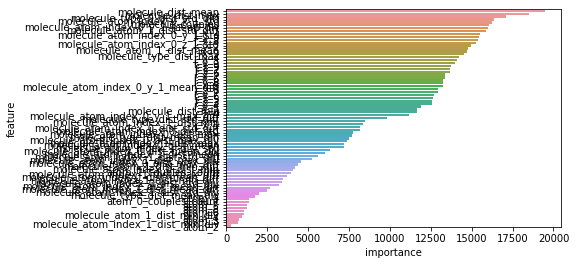

In [136]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [137]:
df_importance.sort_values('importance', ascending=False)

,feature,importance
50,molecule_dist_mean,19501
66,molecule_dist_max,18483
70,molecule_type_0_dist_std_diff,17086
62,molecule_atom_index_0_x_1_std,16341
49,molecule_couples,16240
73,molecule_atom_index_0_y_1_mean_div,16043
67,molecule_atom_1_dist_std_diff,16006
9,r_x_2,15891
52,molecule_atom_index_0_y_1_std,15509
10,r_x_3,15473


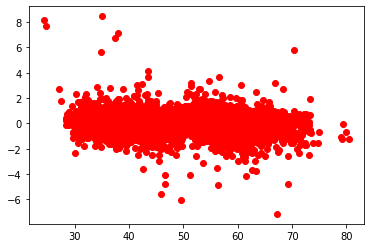

In [138]:
plt.plot(y_val, y_pred- y_val, 'ro')

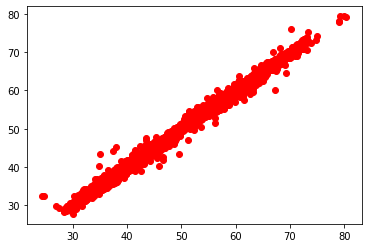

In [139]:
plt.plot(y_val, y_pred, 'ro')

In [140]:
fff

NameError: name 'fff' is not defined

In [ ]:
np.power(2,10)

## Submission Model


In [ ]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=3, n_splits=3, random_state=128):
    model_type =  'lgb' #lgb  cat
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms, False)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms, True)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')


    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        categorical_features = [col for col in X_train if col.startswith('atom_')]
        if model_type == 'lgb':

            model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=1000,
                     categorical_feature = categorical_features)
        
        if model_type == 'cat': 
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [ ]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
        '1JHN': 10,    
        '1JHC': 15,
        '2JHH': 13,
        '2JHN': 13,
        '2JHC': 13,
        '3JHH': 13,
        '3JHC': 15,
        '3JHN': 15
    }


Checking cross-validation scores for each type:

In [ ]:
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## a!!!